In [1]:
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import magic

sc_path = '../cancer_single_cell_data/processed_data_2000.h5ad'
bulk_path =  '../cancer_brca_metabric_bulk_data/data_mrna_illumina_microarray_zscores_ref_diploid_samples.txt'

In [2]:
sc_data = ad.read_h5ad(sc_path)
cell_names = sc_data.obs_names
gene_names = sc_data.var['feature_name']
sc_data_exp = sc_data.X.toarray()
# magic_op = magic.MAGIC()
sc_df = pd.DataFrame(sc_data_exp, index=cell_names, columns=gene_names)

In [3]:
bulk = pd.read_csv(bulk_path, index_col=0, sep='\t')
bulk = bulk.drop(bulk.columns[0], axis=1).T
bulk = bulk.apply(lambda row: row.fillna(row.mean()), axis=1)

In [4]:
common_genes = sc_df.columns.intersection(bulk.columns)
sc_df = sc_df.loc[:, ~sc_df.columns.duplicated()]

bulk = bulk.loc[:, ~bulk.columns.duplicated()]
sc_df = sc_df[common_genes]
bulk = bulk[common_genes]

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold

def apply_scaling(bulk_data, sampled_cells, scaling_method):
    if scaling_method == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_method == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("Unsupported scaling method")

    bulk_data_scaled = scaler.fit_transform(bulk_data)
    sampled_cells_scaled = scaler.fit_transform(sampled_cells)
    return bulk_data_scaled, sampled_cells_scaled

In [6]:
def filter_genes_by_variance(bulk_data, sampled_cells, variance_threshold):
    bulk_var = np.var(bulk_data, axis=0)
    sampled_var = np.var(sampled_cells, axis=0)
    combined_var = bulk_var + sampled_var
    var_cutoff = np.sort(combined_var)[-int(combined_var.shape[0] * variance_threshold)]
    selected_genes = combined_var > var_cutoff
    return bulk_data[:, selected_genes], sampled_cells[:, selected_genes], selected_genes

In [7]:
def plot_bulk_vs_sampled_distribution(bulk_data, sampled_cells, feature_indices=None, bins=50, colors=None):
    """
    Visualize the distribution of bulk_data and sampled single cells by plotting the selected features' distributions.

    Parameters:
    - bulk_data: Original bulk expression data.
    - sampled_cells: Sampled single cell data.
    - feature_indices: List of indices of features to plot. If None, plot the distribution of all features' mean.
    - bins: Number of bins to use in the histogram.
    - colors: List of colors to use for plotting the histograms.
    """
    if colors is None:
        colors = ["blue", "orange"]
        
    if feature_indices is None:
        # Plot mean of all features if no specific indices are selected
        bulk_mean = bulk_data.mean(axis=0)
        sampled_mean = sampled_cells.mean(axis=0)

        plt.figure(figsize=(10, 6))
        sns.histplot(bulk_mean, bins=bins, kde=True, label="Bulk Data (mean)", color=colors[0], stat="density")
        sns.histplot(sampled_mean, bins=bins, kde=True, label="Sampled Cells (mean)", color=colors[1], stat="density")
    else:
        plt.figure(figsize=(10, 6))
        for feature_idx in feature_indices:
            sns.histplot(bulk_data[:, feature_idx], bins=bins, kde=True, label=f"Bulk Feature {feature_idx}", color=colors[0], stat="density")
            sns.histplot(sampled_cells[:, feature_idx], bins=bins, kde=True, label=f"Sampled Cells Feature {feature_idx}", color=colors[1], stat="density")

    plt.title("Distribution Comparison: Bulk Data vs Sampled Single Cells")
    plt.xlabel("Expression Level")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()


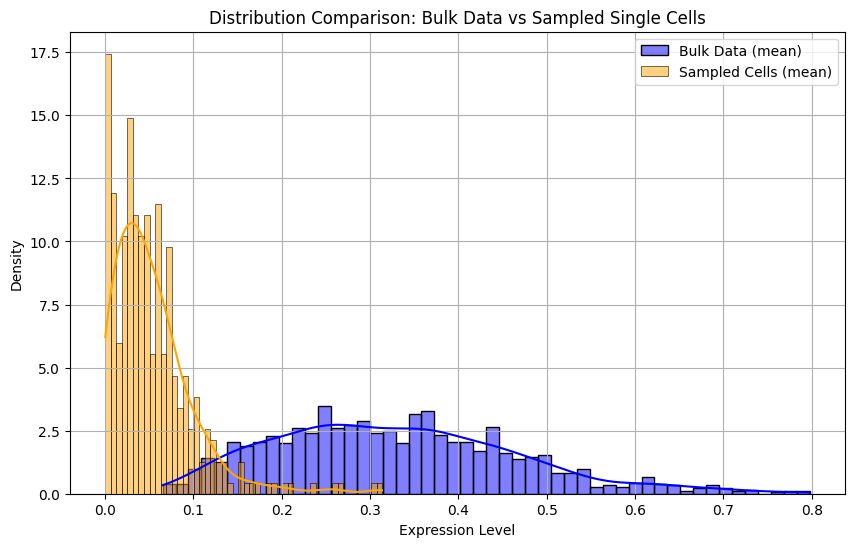

In [10]:
bulk_scaled, sampled_scaled = apply_scaling(bulk.values, sc_df.values, scaling_method='minmax')

# Step 2: Filter genes by variance
bulk_filtered, sampled_filtered, selected_genes = filter_genes_by_variance(bulk_scaled, sampled_scaled, variance_threshold=0.3)
# sampled_filtered = np.log1p(sampled_filtered)

plot_bulk_vs_sampled_distribution(bulk_scaled, sampled_filtered, feature_indices=None, bins=50)


In [11]:
sampled_filtered.shape

(51367, 375)